In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [16]:
import pandas as pd
from ic.eval_ import present_df
import matplotlib.pyplot as plt
import numpy as np
import torch

In [37]:
# result_file = 'out/results/result.h5'
result_file = 'out/results/weight.h5'
ex = pd.read_hdf(result_file, 'ex')
int_df = pd.read_hdf(result_file, 'int_df')
tok_df = pd.read_hdf(result_file, 'tok_df')
piece_df = pd.read_hdf(result_file, 'piece_df')

Text(0.5, 1.0, 'Padding distribution')

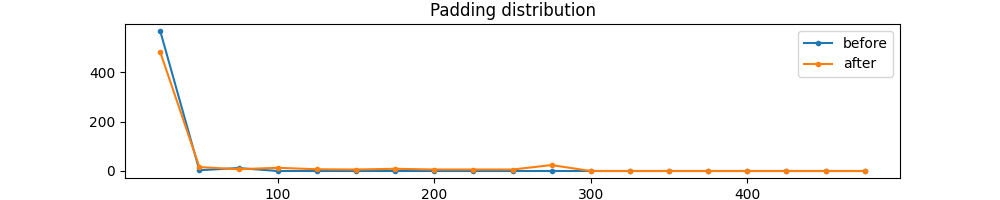

In [10]:
fig, ax = plt.subplots(figsize=(10, 2))
edges = np.arange(0, 500 , 25)
hist_before, _ = np.histogram(piece_df.pad_before, bins=edges)
hist_after, _ = np.histogram(piece_df.pad_after, bins=edges)
ax.plot(edges[1:], hist_before, '.-', label='before')
ax.plot(edges[1:], hist_after, '.-', label='after')
ax.legend()
ax.set_title('Padding distribution')

In [30]:
merged_pieces = piece_df.merge(ex, right_index=True, left_on = 'ids')

In [32]:
merged_pieces.n_inpaint.max()

183

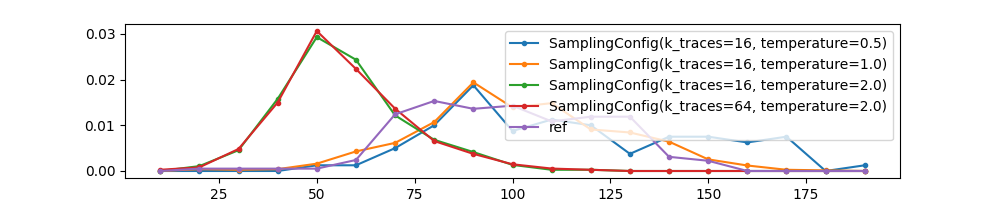

In [43]:
edges = np.arange(0, 200 , 10)
fig, ax = plt.subplots(figsize=(10, 2))
for (exp, sample_conf), g_df in merged_pieces.groupby(['exps', 'params']):
    hist, _ = np.histogram(g_df.n_inpaint, bins=edges, density=True)
    ax.plot(edges[1:], hist, '.-', label=f'{sample_conf}')
ax.legend()

In [29]:
ex.groupby('params').groups.keys()

dict_keys(['SamplingConfig(k_traces=16, temperature=0.5)', 'SamplingConfig(k_traces=16, temperature=1.0)', 'ref'])

In [25]:
present_df(ex, int_df, tok_df)

                                                                                                ic_dev  \
                                                                                                  mean   
exps                                               params                                                
Experiment(time_points_generator=FixedStepTimep... SamplingConfig(k_traces=16, temperature=0.5)  6.057   
                                                   SamplingConfig(k_traces=16, temperature=1.0)  0.011   

                                                                                                          \
                                                                                                abs_mean   
exps                                               params                                                  
Experiment(time_points_generator=FixedStepTimep... SamplingConfig(k_traces=16, temperature=0.5)    8.014   
                                     

In [56]:
tok_merged = ex.merge(tok_df, left_index=True, right_on="ids",how='outer')
tok_merged.columns

Index(['exps', 'params', 'piece', 'sample', 'ids', 'time', 'ic_pitch',
       'ic_vel', 'ic_dur', 'ic_shift', 'ic_mean'],
      dtype='object')

### Calculate the mean IC to be used for normalizing the ICs

In [57]:
normalizer = 1/tok_merged[tok_merged.params == 'ref'].agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})
normalizer

ic_pitch    1.141951
ic_vel      0.312471
ic_dur      0.332826
ic_shift    0.511330
dtype: float64

In [59]:
tok_merged_normed = tok_merged.copy()
tok_merged_normed[['ic_pitch', 'ic_vel', 'ic_dur', 'ic_shift']] = tok_merged[['ic_pitch', 'ic_vel', 'ic_dur', 'ic_shift']] * normalizer.values

In [61]:
tok_merged.groupby('params').agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})

,ic_pitch,ic_vel,ic_dur,ic_shift
params,,,,
"SamplingConfig(k_traces=16, temperature=1.0)",1.193759,2.885858,2.627582,1.714499
ref,0.875694,3.200298,3.004571,1.955684


In [62]:
tok_merged_normed.groupby('params').agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})

,ic_pitch,ic_vel,ic_dur,ic_shift
params,,,,
"SamplingConfig(k_traces=16, temperature=1.0)",1.363214,0.901747,0.874528,0.876675
ref,1.000000,1.000000,1.000000,1.000000


In [36]:
for i in ['temp'] + list(range(4)):
    file = f'out/experiment-time-points-generator-fixedsteptimepoints-step-0-5-weight-movingaverage-window-size-0-5-c-1-0-channel-weight-1-07-0-3-0-45-0-73-dataset-datapiece-batik-ic-curve-none-match-metric-ic/samplingconfig-k-traces-16-temperature-1-0/kv332_2_start_149_nodes_177/{i}/ic.pt'
    print(i, (torch.load(file).ic_tok * normalizer.values).mean(0).tolist())

temp [0.9381523099671922, 0.9733174237153968, 1.353154444354705, 1.4300356222852666]
0 [0.9957575399633618, 0.8446423510521419, 1.0394252040011718, 1.2409117388830726]
1 [1.2600783701223501, 0.8603173659492088, 1.134012008038527, 1.136829680510853]
2 [1.2118009863334855, 0.8583741322637384, 1.2935531969189695, 1.1860657703700246]
3 [1.641407599530527, 0.9472145251321012, 1.2341045549989191, 1.4509081765701826]


In [9]:
# tok_10s = tok_merged[tok_merged.exps=="Experiment(time_points_generator=FixedStepTimepoints(step=0.5), weight=MovingAverage(window_size=0.5, c=1.0), dataset=DataCache(label='validation', n_inpaint=10.0, n_pieces=200), ic_curve=None)"]
time_inpaint =tok_merged.groupby('piece').agg({'time' : 'max'})
time_inpaint.agg({'time' : ['min', 'mean', 'max']})

,time
min,9.780000
mean,9.896666
max,10.000000


In [10]:
time_inpaint.hist()

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

In [21]:
tok_df.shape, merged.shape

((558327, 7), (558327, 11))

In [5]:
time_inpaint = merged[merged.params == 'ref'].groupby('piece').agg({'time' : 'max'})
time_inpaint.agg({'time' : ['min', 'mean', 'max']})

,time
min,4.180000
mean,13.538051
max,52.060001


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

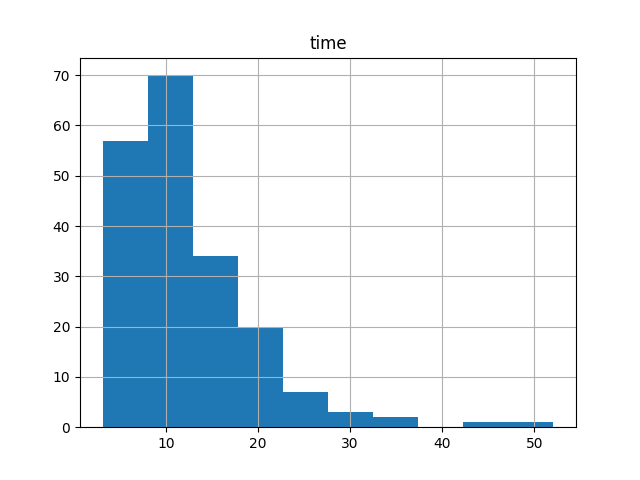

In [35]:
# fig, ax = plt.subplots()
time_inpaint.hist()